In [28]:
import os
import math
import gzip
from typing import Dict, Any
import time

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, GPT2LMHeadModel
from datasets import load_dataset
import pandas as pd

In [29]:
# 0. DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating on device:", device)

# 1. TOKENIZER / MODEL NAMES
tokenizer_names = [
    "unigram",                 # 2. Byte-level BPE
    # 3. Character-level              # 4. Your custom unigram
]

# 2. LOAD RAW VALIDATION DATA ONCE
raw_eval = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:100%]")
#raw_eval = raw_eval.filter(lambda x: len(x["text"].strip()) > 0)
eval_texts = list(raw_eval["text"])
total_chars = sum(len(t) for t in eval_texts)
print(f"#test examples: {len(eval_texts)}, total chars: {total_chars}")

Evaluating on device: cpu
#test examples: 4358, total chars: 1285622


In [30]:
# 3. EVALUATION FUNCTION FOR ONE MODEL
def evaluate_model(name: str) -> Dict[str, Any]:
    print(f"\n Evaluating tokenizer: {name}")

    # 3.1 Load tokenizer & model from disk
    model_dir = os.path.join("model_512", name)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = GPT2LMHeadModel.from_pretrained(model_dir).to(device)
    model.eval()

    vocab_size = len(tokenizer)
    n_params = sum(p.numel() for p in model.parameters())

    # 3.2 TRUE CHARACTER COUNT FROM TOKENIZATION
    print("Computing true character usage...")
    free_enc = tokenizer(
        eval_texts,
        padding=False,
        truncation=True,
        max_length=512,
    )

    chars_from_tokens = 0
    total_tokens_in_free_enc = 0

    for ids in free_enc["input_ids"]:
        decoded = tokenizer.decode(ids, skip_special_tokens=True)
        chars_from_tokens += len(decoded)
        total_tokens_in_free_enc += len(ids)

    tokens_per_char = total_tokens_in_free_enc / chars_from_tokens
    
    # 3.4 PREPARE PADDED DATASET FOR LOSS / PERPLEXITY
    def encode(batch):
        texts = list(batch["text"])
        return tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=512,
        )

    eval_ds = raw_eval.map(encode, batched=True)
    eval_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])
    eval_loader = DataLoader(eval_ds, batch_size=8)
    
    # 3.5 COMPUTE TOTAL NLL, LOSS, PERPLEXITY
    total_nll = 0.0            # sum of nats over all non-pad tokens
    total_nonpad_tokens = 0
    total_forward_tokens = 0        # tokens processed (non-pad)

    with torch.no_grad():
        for batch in eval_loader:
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            labels = inputs.clone()
            labels[attention_mask == 0] = -100

            nonpad = (labels != -100).sum().item()
            if nonpad == 0:
                continue

            outputs = model(
                input_ids=inputs,
                attention_mask=attention_mask,
                labels=labels,
            )

            # loss accounting
            loss = outputs.loss.item()
            batch_nll = loss * nonpad
            total_nll += batch_nll
            total_nonpad_tokens += nonpad

        avg_loss = total_nll / total_nonpad_tokens
        ppl = math.exp(avg_loss)
        
        # 3.6 BITS-PER-TOKEN & BITS-PER-CHAR
        total_bits = total_nll / math.log(2)
        bits_per_char = total_bits / total_chars
        
        # 3.7 PACK RESULTS
        return {
            "tokenizer": name,
            "vocab_size": vocab_size,
            "params_millions": n_params / 1e6,
            "tokens_per_char": tokens_per_char,
            "val_loss": avg_loss,
            "perplexity": ppl,
            "bits_per_char": bits_per_char,
            }
# 4. RUN EVALUATION FOR ALL TOKENIZERS & COLLECT RESULTS
all_results = [evaluate_model(name) for name in tokenizer_names]

results_df = pd.DataFrame(all_results).round(2)

print("\n Summary table")
print(results_df)


 Evaluating tokenizer: unigram
Computing true character usage...


Map: 100%|██████████| 4358/4358 [00:00<00:00, 7698.56 examples/s]



 Summary table
  tokenizer  vocab_size  params_millions  tokens_per_char  val_loss  \
0   unigram       32000            67.89             0.24      5.07   

   perplexity  bits_per_char  
0      158.54           1.86  


## 95\% conf interval

In [31]:
from scipy import stats

print("\n GENERATION TESTS")

prompt = "This is a great day to"
n_runs = 50
df = n_runs - 1
t_95 = stats.t.ppf(1-0.05/2, df)

for name in tokenizer_names:
    print(f"\n Generating with: {name}")
    
    model_dir = f"model/{name}"
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = GPT2LMHeadModel.from_pretrained(model_dir).to(device)
    model.eval()

    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    inputs = inputs.to(device)

    # GENERATION TIME 
    tokens_per_sec_runs = []
    gen_times = []
    new_tokens_counts = []

    sample_text = None  # only store the first output

    for run in range(n_runs):
        with torch.no_grad():
            if device.type == "cuda":
                torch.cuda.synchronize()
            t_gen0 = time.time()

            generated = model.generate(
                **inputs,
                max_new_tokens=50,   # fixed for fairness
                do_sample=True,
                temperature=0.9,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id,
            )

            if device.type == "cuda":
                torch.cuda.synchronize()
            t_gen1 = time.time()

        generation_time = t_gen1 - t_gen0

        # count new tokens only
        prompt_len = inputs["input_ids"].shape[1]
        total_len = generated.shape[1]
        n_gen_tokens = max(total_len - prompt_len, 0)

        tokens_per_sec = n_gen_tokens / generation_time

        tokens_per_sec_runs.append(tokens_per_sec)
        gen_times.append(generation_time)
        new_tokens_counts.append(n_gen_tokens)

        if run == 0:  # save only the first generation
            sample_text = tokenizer.decode(generated[0], skip_special_tokens=True)

    # MEAN + 95% CONFIDENCE INTERVAL
    mean_tps = sum(tokens_per_sec_runs) / n_runs

    var = sum((x - mean_tps) ** 2 for x in tokens_per_sec_runs) / (n_runs - 1)
    std_tps = math.sqrt(var)
    se_tps = std_tps / math.sqrt(n_runs)
    ci_low = mean_tps - t_95 * se_tps
    ci_high = mean_tps + t_95 * se_tps

    mean_gen_time = sum(gen_times) / n_runs
    mean_new_tokens = sum(new_tokens_counts) / n_runs

    # OUTPUT
    print(sample_text)  # ONE example per model

    print(f"[{name}]")
    print(f"  mean_tokens_per_sec:         {mean_tps:.2f}")
    print(f"  tokens_per_sec_std:          {std_tps:.2f}")
    print(f"  tokens_per_sec_95%CI:        [{ci_low:.2f}, {ci_high:.2f}]")


 GENERATION TESTS

 Generating with: unigram
This is a great day to the y and s on , and his a ed , the r a as a ' s ( - k ham on on on . ) , but on ( A ) , the d a , F ive ing for the n on for a ham and the
[unigram]
  mean_tokens_per_sec:         87.00
  tokens_per_sec_std:          5.27
  tokens_per_sec_95%CI:        [85.51, 88.50]


In [32]:
print("\n PROMPT PROCESSING BENCHMARK")

long_prompt = (
    """This benchmark prompt is intentionally extended to approximately one thousand characters to evaluate how different tokenization strategies and model architectures process long, information-dense inputs under realistic conditions. It includes diverse elements such as technical terminology from machine learning, like stochastic gradient descent, entropy regularization, eigenvector drift, nonlinear optimization, and transformer attention patterns. It also integrates multilingual fragments such as hej, guten Tag, bonjour, hola, こんにちは, 你好, γειά σου, and привет to stress Unicode handling. Numerical values including 3.14159, 0.00027, and 42, alongside symbolic expressions like α→β→γ and ∫x² dx, test symbolic segmentation. Short code pieces such as for(i=0;i<10;i++){sum+=i;} and JSON-like fragments {"key":42,"msg":"hello"} further diversify the prompt, ensuring broad tokenizer coverage across subword granularity and vocabulary structure."""
)

max_len_prompt = 1000
n_runs = 50
df = n_runs-1
t_95 = stats.t.ppf(1-0.05/2, df)

def mean_std_ci(values):
    vals = [v for v in values if not math.isnan(v)]
    m = sum(vals) / len(vals)
    if len(vals) > 1:
        var = sum((x - m)**2 for x in vals) / (len(vals) - 1)
        s = math.sqrt(var)
        se = s / math.sqrt(len(vals))
        ci_low = m - t_95 * se
        ci_high = m + t_95 * se
    else:
        s = float("nan")
        ci_low = ci_high = float("nan")
    return m, s, ci_low, ci_high

for name in tokenizer_names:
    print(f"\n Prompt processing for: {name}")

    model_dir = f"model/{name}"
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = GPT2LMHeadModel.from_pretrained(model_dir).to(device)
    model.eval()

    total_times = []
    n_tokens = None

    for run in range(n_runs):

        # START total time
        t0 = time.time()

        # Tokenization
        encoded = tokenizer(
            long_prompt,
            return_tensors="pt",
            truncation=True,
            max_length=max_len_prompt,
            add_special_tokens=False,
        )

        if n_tokens is None:
            n_tokens = encoded["input_ids"].shape[1]

        encoded = {k: v.to(device) for k, v in encoded.items()}

        # Forward pass (prompt only)
        with torch.no_grad():
            if device.type == "cuda":
                torch.cuda.synchronize()
            t_fwd0 = time.time()
            _ = model(**encoded)
            if device.type == "cuda":
                torch.cuda.synchronize()
            t_fwd1 = time.time()

        # END total time
        total_time = t_fwd1 - t0
        total_times.append(total_time)

    # STATISTICS
    mean_t, std_t, ci_low, ci_high = mean_std_ci(total_times)

    # REPORT
    print(f"  total_time_mean:        {mean_t:.6f} sec")
    print(f"  total_time_std:         {std_t:.6f} sec")
    print(f"  total_time_95%CI:       [{ci_low:.6f}, {ci_high:.6f}]")


 PROMPT PROCESSING BENCHMARK

 Prompt processing for: unigram
  total_time_mean:        0.064718 sec
  total_time_std:         0.005439 sec
  total_time_95%CI:       [0.063172, 0.066263]


# Graph of Epochs vs training loss

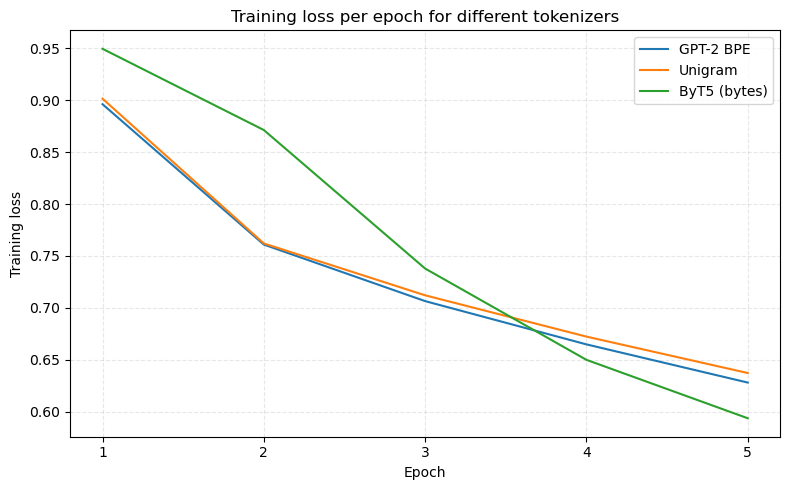

In [2]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3, 4, 5]

# Training losses
gpt2_losses =    [0.8962, 0.7609, 0.7064, 0.6647, 0.6279]
unigram_losses = [0.9015, 0.7620, 0.7120, 0.6722, 0.6371]
byt5_losses =    [0.9496, 0.8713, 0.7378, 0.6498, 0.5935]

plt.figure(figsize=(8, 5))

plt.plot(epochs, gpt2_losses, label="GPT-2 BPE")
plt.plot(epochs, unigram_losses, label="Unigram")
plt.plot(epochs, byt5_losses, label="ByT5 (bytes)")

plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Training loss per epoch for different tokenizers")
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()